In [1]:
pip install graphviz

  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
from graphframes import GraphFrame

In [3]:
file_airport = '/data/students/bigdata_internet/lab5/airports.csv'

In [4]:
file_airlines = '/data/students/bigdata_internet/lab5/airlines.csv'

In [5]:
file_routes = '/data/students/bigdata_internet/lab5/routes.csv'

In [6]:
airports = spark.read.load(file_airport,sep = ',',format = "csv",header =True , inferSchema =True)

In [7]:
airlines = spark.read.load(file_airlines,sep = ',',format = "csv",header =True , inferSchema =True)

In [8]:
routes = spark.read.load(file_routes,sep = ',',format = "csv",header =True , inferSchema =True)

In [9]:
airports.createOrReplaceTempView("airports")

In [10]:
#2.1 countries in the world with more than 200 airports

In [11]:
countries_200airport = spark.sql("""
SELECT country, count(id) AS countAirPort 
FROM airports 
GROUP BY country""")\
.filter('countAirPort > 200').orderBy('countAirPort', ascending=False)

In [12]:
countries_200airport.show()

[Stage 7:======================================================>(199 + 1) / 200]

+-------------+------------+
|      country|countAirPort|
+-------------+------------+
|United States|        1512|
|       Canada|         430|
|    Australia|         334|
|       Russia|         264|
|       Brazil|         264|
|      Germany|         249|
|        China|         241|
|       France|         217|
+-------------+------------+



In [13]:
routes.createOrReplaceTempView("airlines")

In [14]:
#2.2 Top-5 airlines by total number of flights

In [15]:
Top_numFlights = spark.sql("""
SELECT airline_id , count(airline_id) AS numFlights 
FROM airlines 
GROUP BY airline_id""").orderBy('numFlights',ascending=False)

In [16]:
top5 = Top_numFlights.show(5)

[Stage 9:====================================================>  (190 + 1) / 200]

+----------+----------+
|airline_id|numFlights|
+----------+----------+
|      4296|      2484|
|        24|      2354|
|      5209|      2180|
|      2009|      1981|
|      5265|      1960|
+----------+----------+
only showing top 5 rows



In [17]:
airline_icao = airlines.select('airline_id', 'name', 'icao')

In [18]:
#2.2 Top 10 airlines with airline name, airline icao code and number of flights

In [19]:
top_10airlines = airline_icao.join(Top_numFlights, on='airline_id', how='inner')
top_10airlines.show(10)

[Stage 14:===================================================>  (190 + 1) / 200]

+----------+--------------------+----+----------+
|airline_id|                name|icao|numFlights|
+----------+--------------------+----+----------+
|      4296|             Ryanair| RYR|      2484|
|        24|   American Airlines| AAL|      2354|
|      5209|     United Airlines| UAL|      2180|
|      2009|     Delta Air Lines| DAL|      1981|
|      5265|          US Airways| USA|      1960|
|      1767|China Southern Ai...| CSN|      1454|
|      1758|China Eastern Air...| CES|      1263|
|       751|           Air China| CCA|      1260|
|      4547|  Southwest Airlines| SWA|      1146|
|      2297|             easyJet| EZY|      1130|
+----------+--------------------+----+----------+
only showing top 10 rows



In [20]:
topRoutes = spark.sql("""
    SELECT
        airport_source,
        airport_destination,
        airport_source_id,
        airport_destination_id,
        COUNT(*) AS count
    FROM
        airlines
    GROUP BY
        airport_source,
        airport_destination,
        airport_source_id,
        airport_destination_id
""").orderBy('count',ascending=False)

In [21]:
from pyspark.sql.functions import col

In [22]:
airportsourcename = airports.select(
    col('id').alias('airport_source_id'),
    col('name').alias('source_name'),
    col('city').alias('source_city')
)

In [23]:
airportdestname = airports.select(
    col('id').alias('airport_destination_id'),
    col('name').alias('destination_name'),
    col('city').alias('destination_city')
)

In [24]:
joiningSource = topRoutes.join(airportsourcename, on='airport_source_id', how='inner')

In [25]:
joiningDest = joiningSource.join(airportdestname, on='airport_destination_id', how='inner')

In [26]:
favoriteRoutes = joiningDest.select('source_name','source_city','destination_name','destination_city','count')

In [27]:
#2.3 Top-5 routes in the world in descending order

In [28]:
favoriteRoutes.show(5,truncate = False)   

[Stage 24:====================================================> (194 + 1) / 200]

+------------------------------------------------+-----------+-------------------------------------------------+----------------+-----+
|source_name                                     |source_city|destination_name                                 |destination_city|count|
+------------------------------------------------+-----------+-------------------------------------------------+----------------+-----+
|Chicago O'Hare International Airport            |Chicago    |Hartsfield Jackson Atlanta International Airport |Atlanta         |20   |
|Hartsfield Jackson Atlanta International Airport|Atlanta    |Chicago O'Hare International Airport             |Chicago         |19   |
|Phuket International Airport                    |Phuket     |Suvarnabhumi Airport                             |Bangkok         |13   |
|Chicago O'Hare International Airport            |Chicago    |Louis Armstrong New Orleans International Airport|New Orleans     |13   |
|Hong Kong International Airport                

In [29]:
routes.count()

67663

In [30]:
Cleanroutes = routes.filter((routes['airport_source_id'] != '\\N') & (routes['airport_destination_id'] != '\\N'))

In [31]:
#3.1 423 lines are filtered out

In [32]:
Cleanroutes.count()   

67240

In [33]:
v = airports.select('id','name')

In [34]:
v = v.withColumn("id", v.id.cast("string"))

In [35]:
e = Cleanroutes.select(col('airport_source_id').alias('src'),col('airport_destination_id').alias('dst'))

In [36]:
e = e.withColumn("src", e.src.cast("string")).withColumn("dst", e.dst.cast("string"))

In [37]:
g = GraphFrame(v, e)

In [38]:
gDeg=g.inDegrees

In [39]:
gOut=g.outDegrees

In [40]:
djoin=gOut.join(gDeg,on = 'id',how= 'inner')

In [41]:
ratio_df = djoin.withColumn("out_in_ratio", col("outDegree") / col("inDegree"))

In [42]:
rDec = ratio_df.orderBy('out_in_ratio',ascending=False)

In [43]:
ap = airports.select(col('id').cast('string').alias('id'), 'name')

In [44]:
idNameRatio = rDec.join(ap, on = 'id',how = 'inner')

In [45]:
topFiveRatio = idNameRatio.orderBy('out_in_ratio',ascending = False)

In [46]:
top5WithName = topFiveRatio.selectExpr('name','inDegree as edgeIn','outDegree as edgeOut','out_in_ratio as ratio','id')
#4.1 the highest ratio of outgoing edges overincoming ones

In [47]:
top5WithName.show(5,truncate = False)

[Stage 37:=================================================>    (146 + 2) / 160]

+----------------------------------------------+------+-------+-----+----+
|name                                          |edgeIn|edgeOut|ratio|id  |
+----------------------------------------------+------+-------+-----+----+
|Bunia Airport                                 |1     |3      |3.0  |1033|
|Pikangikum Airport                            |2     |5      |2.5  |5521|
|Transilvania Târgu Mureş International Airport|2     |5      |2.5  |1662|
|Ivalo Airport                                 |1     |2      |2.0  |428 |
|Bahir Dar Airport                             |1     |2      |2.0  |1111|
+----------------------------------------------+------+-------+-----+----+
only showing top 5 rows



In [48]:
oneflightfromTO = g.bfs(fromExpr="id = '1526'", toExpr="id != '1526'").distinct()

In [49]:
print(oneflightfromTO.count())  #4.2.1 number of airports you can reach from the city of "Torino" taking exactly 1flight

[Stage 47:====================================================> (194 + 1) / 200]

29


In [50]:
oneflighttoTO =g.bfs(fromExpr="id != '1526'", toExpr="id = '1526'").distinct()

In [51]:
print(oneflighttoTO.count())  
#4.2.2 number of airports you can reach the city of "Torino" taking exactly1 flight
#The number of incoming edges and the number of outgoing edges are equal for Torino, it implies that Torino 
#is well-connected with other airports in terms of both arriving and departing flights.

[Stage 58:=====================================================>(199 + 1) / 200]

29


In [54]:
chain2 = g.find("(v1)-[e1]->(v2); (v2)-[e2]->(v3)").filter(col('v1')['id'] == '1526').select('v3').distinct()

In [55]:
chain2.count()  #4.3 number of airports you can reach from the city of "Torino" taking exactly 2flight

590

In [56]:
to_to = g.shortestPaths(landmarks=['1526'])

In [57]:
from pyspark.sql.functions import expr, size

In [80]:
to_LA = g.shortestPaths(landmarks=['3484'])

In [81]:
vertices_and_edge_LA = to_LA.select("id", "distances").\
    withColumn("num_edges_LA", expr("filter(map_values(distances), distance -> distance > 0)"))

In [82]:
vertices_and_edge_to = to_to.select("id", "distances").\
    withColumn("num_edges_to", expr("filter(map_values(distances), distance -> distance > 0)"))

In [83]:
join_la_to= vertices_and_edge_to.join(vertices_and_edge_LA, "id")

In [84]:
df_with_int = join_la_to.withColumn("int_value", col("num_edges_LA")[0].cast("int"))

In [85]:
final = df_with_int.withColumn("int_value2", col("num_edges_TO")[0].cast("int"))

In [86]:
ff = final.filter("int_value is not null and int_value2 is not null")

In [87]:
LAlessThanTO = ff.filter("int_value < int_value2")

In [88]:
LAlessThanTO.count()  #4.4.1 number of airports in the world you can reach "Los AngelesInternational Airport" using less hops
#than to reach the city of Torino

1830

In [89]:
TolessThanLA =ff.filter("int_value > int_value2")

In [90]:
TolessThanLA.count()  #4.4.2 number of airports in the world you can reach the city of Torino "Los AngelesInternational Airport" using less hops
#than to reach the city of Torino

93

In [91]:
sameNum = ff.filter("int_value == int_value2")

In [92]:
sameNum.count()  #4.4.3 airports in the world you can reach with the same numberof hops Torino and "Los Angeles International Airport

1244

In [97]:
sc.setCheckpointDir("/user/s310279/lab5/tmp_ckpts")

24/03/13 09:01:46 WARN spark.SparkContext: Spark is not running in local mode, therefore the checkpoint directory must not be on the local filesystem. Directory '/user/s310279/lab5/tmp_ckpts' appears to be on the local filesystem.


In [98]:
connComp=g.connectedComponents()

24/03/13 09:01:47 WARN execution.CacheManager: Asked to cache already cached data.
24/03/13 09:01:47 WARN execution.CacheManager: Asked to cache already cached data.
24/03/13 09:01:48 WARN execution.CacheManager: Asked to cache already cached data.
24/03/13 09:01:48 WARN execution.CacheManager: Asked to cache already cached data.
24/03/13 09:01:48 WARN execution.CacheManager: Asked to cache already cached data.
24/03/13 09:01:50 WARN execution.CacheManager: Asked to cache already cached data.
24/03/13 09:01:50 WARN execution.CacheManager: Asked to cache already cached data.
24/03/13 09:01:50 WARN execution.CacheManager: Asked to cache already cached data.


In [99]:
connComp.orderBy("component")

DataFrame[id: string, name: string, component: bigint]

In [100]:
connComp.createOrReplaceTempView("comp")

In [101]:
sizeComp = spark.sql("SELECT component, COUNT(*) as count FROM comp GROUP BY component")

In [102]:
sizeComp.filter("count>1").show()  #4.5 connected components and their size

+-------------+-----+
|    component|count|
+-------------+-----+
| 266287972371|    4|
| 352187318292|    4|
| 721554505752|    2|
|1460288880657|    2|
| 300647710730|   10|
|           11| 3188|
|           23|    4|
+-------------+-----+



In [103]:
sizeComp.filter("count>1").count()  #4.5 number of connected components

7

In [104]:
#4.6 the subgraph of the flights that are performed by twodifferent airlines (identified by the ICAO), each involving at least 5 cities.

In [110]:
icao_joined = Cleanroutes.join(airlines, Cleanroutes.airline_id == airlines.airline_id).select(
    Cleanroutes['airport_source_id'].alias('src'),
    Cleanroutes['airport_destination_id'].alias('dst'),
    airlines['airline_id'],
    airlines['icao'].alias('icao'),
    airlines['name'].alias('airline_name')
)

In [111]:
icao_joined.createOrReplaceTempView('icao_joined')

In [112]:
e_icao =spark.sql('select src,dst,icao,airline_name from icao_joined where icao = "KOR" or icao ="VKH" ')

In [113]:
v_cities = airports.select("id","city")

In [114]:
g_icao = GraphFrame(v_cities,e_icao)

In [115]:
g_final = g_icao.dropIsolatedVertices()

In [116]:
testCity=icao_joined.join(airports,icao_joined.airline_id ==airports.id ).select(icao_joined['icao'],airports['city'])

In [117]:
testCity.createOrReplaceTempView('testCity')

In [118]:
#to find icao that involve 8 cities(more than 5)
testCity2 = spark.sql('''
SELECT icao ,COUNT(city)
FROM testCity
GROUP BY icao
HAVING COUNT(city) = 8''')

In [119]:
import networkx as nx

In [120]:
from graphviz import Digraph
def vizGraph(edge_list,node_list):
    Gplot=Digraph()
    edges=edge_list.collect()
    nodes=node_list.collect()
    for row in edges:
        Gplot.edge(str(row['src']),row['dst'],label=str(row['icao']))
    for row in nodes:
        Gplot.node(str(row['id']),label=str(row['city']))
    return Gplot

In [121]:
Gplot=vizGraph(g_final.edges,g_final.vertices)
#Gplot 
#4.7 plot a subgraph of the flights that are performed by two different airlines 
#(identified by the ICAO), each involving at least 5 cities
#4.6 airline Names an their icao :
#KOR : Air Koryo
#VKH : Viking Hellas


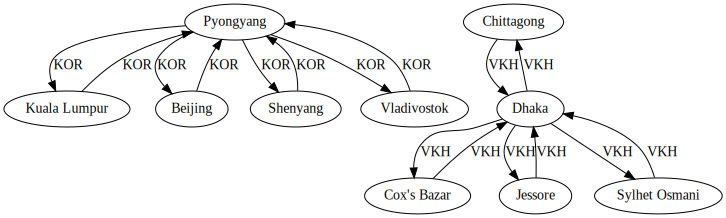

In [122]:
Gplot